algorithm
画像を入力
全画像をVGG16にかけて、局所特徴量の抽出
全局所特徴量をk-meansによってカテゴライズして、ヒストグラムのビンとする
ビンをもとに、全画像に対してBag of VisualWordsでヒストグラムを作り、特徴ベクトルを作成
全特徴ベクトルに対して、k-NN グラフを作成し、cycle consistency によってカテゴリを作成する
カテゴリ数の表示及び、同一シーンの視点変化させた画像群に対して、同じカテゴリに属しているかの判断を行う

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing import image
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import sys
import cv2
import os
import shutil
import networkx as nx
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
DATA_DIR = '../data/'
VIDEOS_DIR = '../data/video/'                        # The place to put the video
TARGET_IMAGES_DIR = '../data/images/target/'         # The place to put the images which you want to execute clustering
CLUSTERED_IMAGES_DIR = '../data/images/cycle/'   # The place to put the images which are clustered
IMAGE_LABEL_FILE ='image_label_cycle.csv'                  # Image name and its label

In [3]:
num_img = 285 #画像の枚数
DG = nx.DiGraph()

In [4]:
clusters=50
video_file='IMG_2140.MOV'
image_file_temp='img_%s.png'
input_video=False
col=7*7
channels=512
k_NN=4

In [5]:
def __feature_extraction(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # resize
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # add a dimention of samples
    x = preprocess_input(x)  # RGB 2 BGR and zero-centering by mean pixel based on the position of channels

    feat = model.predict(x)  # Get image features #1次元化しないで7x7x512

    return feat

In [6]:
print('Label images...')
# Load a model
model = VGG16(weights='imagenet', include_top=False)
# Get images
images = [f for f in os.listdir(TARGET_IMAGES_DIR) if f[-4:] in ['.png', '.jpg']]
assert(len(images)>0)

X = []
X_vector = []
for i in range(len(images)):
    # Extract image features
    feat = __feature_extraction(model, TARGET_IMAGES_DIR+images[i])
    X.append(feat)
# Clustering images by k-means++
X = np.array(X)
X = X.reshape([num_img*col, channels])
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
centr = np.array(kmeans.cluster_centers_)

Label images...
Instructions for updating:
Colocations handled automatically by placer.


各画像の特徴ベクトルの作成 (Bag of Visual Words)

In [7]:
for i in range(num_img-1):
    X_hist = [0]*col
    for j in range(col-1):
        dist = [0]*col
        for k in range(clusters-1):
            diff = X[i*col+j,] - centr[k,]
            dist[k] = np.linalg.norm(diff)
        X_hist[dist.index(min(dist))] += 1
    X_vector.append(X_hist)
X_vector = np.array(X_vector) #feature vector
print(np.shape(X_vector)) #(284,49)? (285,49)
DG.add_nodes_from(range(1, len(X_vector))) #make visual k-NN Graph

(284, 49)


Bag of Visual Wordsのヒストグラムの画像作成

In [ ]:
df = pd.DataFrame(X_vector)
df = df.transpose()
for i in range(1, len(X_vector)):
    plt.figure()
    df[i-1].plot.bar()
    plt.savefig("../data/hist/hist"+str(i)+".jpg")
    plt.close("all")

k-NNグラフの作成

In [33]:
cycle = []
X_list = X_vector
X_list = np.array(X_list)

lbl = []
for i in range(1, len(X_list)+1):
    lbl.append([i])
X_list = np.append(X_list,lbl,axis=1) # X_list = [,,,,,img_num]

while len(X_list)>1:
    node_I = []
    for i in range(len(X_list)-1):
        L2 = []
        for j in range(len(X_list)-1):
            if i!=j:
                diff = X_list[i,] - X_list[j,]
                np.delete(diff, len(diff)-1,0)
                L2.append([i+1,j+1,np.linalg.norm(diff)]) #L2norm [I, kNN, L2norm]
        L2 = np.array(L2)
        if len(L2)!=0:
            L2 = L2[np.argsort(L2[:,2])]
            L2 = np.delete(L2, slice(k_NN, len(L2)),0)
            if L2[0,1] in node_I or L2[0,1] == i:
                break
            else:
                node_I.append(L2[0,1])
                for m in range(len(L2)-1):
                    DG.add_edges_from([(i,L2[m,1])])
    node_I.append(X_list[0,col])
    cycle.append(np.array(node_I))
    for l in range(len(node_I)):
        for n in range(len(X_list)-1):
            if node_I[l] == X_list[n,col]:
                X_list = np.delete(X_list, n, 0)

In [35]:
cycle = np.array(cycle)
print(cycle)
print(np.shape(cycle))

[array([6., 1.]) array([ 6.,  3.,  4.,  7., 12., 10.,  2.])
 array([3., 4., 1., 5., 5.]) array([3., 7., 4., 8.]) array([6., 3., 9.])
 array([ 2., 11.]) array([ 5.,  8., 13.]) array([ 7., 14.])
 array([ 6., 15.]) array([ 5.,  6.,  4., 16.]) array([ 5.,  3., 17.])
 array([ 2., 18.]) array([ 2.,  4.,  8., 19.])
 array([ 3.,  7.,  1.,  5., 20.]) array([ 6.,  4., 21.]) array([ 3., 22.])
 array([ 2., 23.]) array([ 8.,  5.,  6., 14.,  2.,  3., 24.])
 array([ 4.,  5., 13.,  1.,  2., 25.])
 array([ 4., 12.,  5.,  1.,  3., 14., 11.,  9., 10., 26.])
 array([11.,  4.,  7.,  2., 13., 10.,  8.,  9., 27.])
 array([ 3.,  6.,  1., 12.,  9.,  7.,  8., 28.])
 array([ 5., 10., 11.,  8.,  6.,  7., 29.])
 array([ 9., 10.,  7.,  5.,  6., 30.]) array([ 9.,  6.,  4.,  5., 31.])
 array([ 5.,  3.,  4., 32.]) array([ 2.,  3., 33.]) array([ 2., 34.])
 array([11.,  6.,  8.,  9., 35.]) array([ 5.,  7.,  8., 36.])
 array([ 6.,  7.,  4.,  8., 37.]) array([ 6.,  3.,  7., 38.])
 array([ 2.,  6., 39.]) array([ 5., 40.])


k-NNグラフの表示

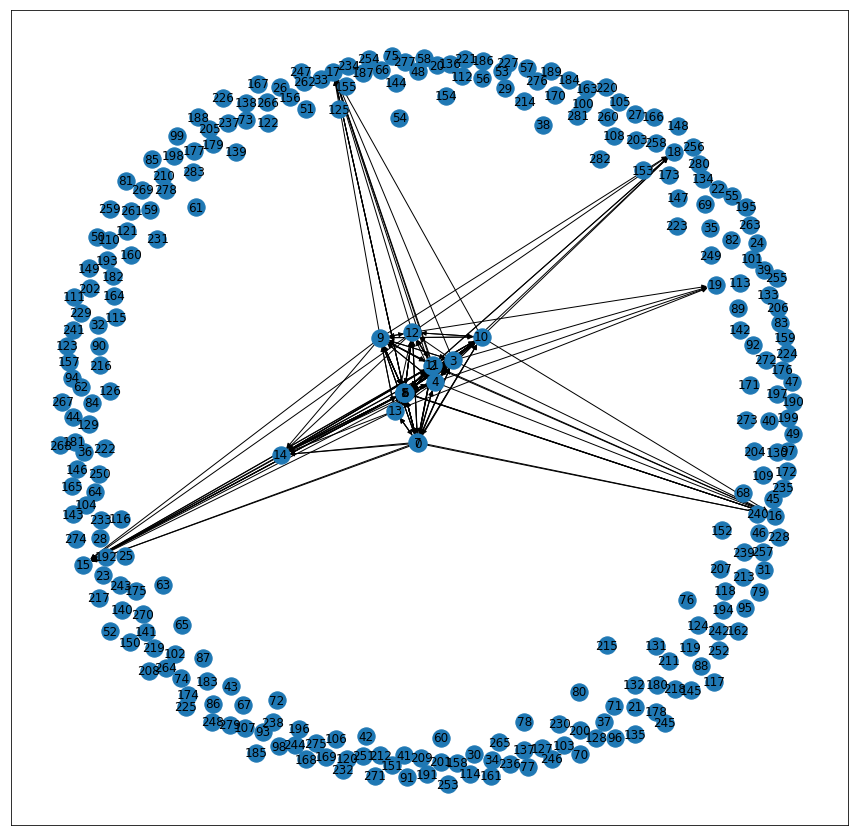

In [34]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(DG)
nx.draw_networkx(DG,pos)
plt.show()

画像をクラスごとに分類

In [56]:
labels = []
for i in range(1, num_img+1):
    labels.append(i)
df = pd.DataFrame({'image': images, 'label': labels})
df.to_csv(DATA_DIR+IMAGE_LABEL_FILE, index=False)

In [50]:
if os.path.exists(CLUSTERED_IMAGES_DIR):
    shutil.rmtree(CLUSTERED_IMAGES_DIR)

for i in range(len(cycle)-1):
    print('Copy and paste cycle %s images.' %i)
    new_dir = CLUSTERED_IMAGES_DIR + str(i) + '/'
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    for j in range(len(cycle[i,])-1):
        clustered_images = df[df['label']==cycle[i,j]]['image'].values
        for ci in clustered_images:
            src = TARGET_IMAGES_DIR + ci
            dst = CLUSTERED_IMAGES_DIR + str(label) + '/' + ci
            shutil.copyfile(src,dst)

Copy and paste cycle 0 images.


IndexError: too many indices for array